In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
from pylab import rcParams

import tensorflow as tf
from keras import optimizers, Sequential
from keras.models import Model
import keras.utils 
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed
from keras.callbacks import ModelCheckpoint, TensorBoard

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score

from numpy.random import seed
seed(7)
import tensorflow 
tensorflow.random.set_seed(11)

from sklearn.model_selection import train_test_split

SEED = 123 #used to help randomly select the data points
DATA_SPLIT_PCT = 0.2

rcParams['figure.figsize'] = 8, 6
LABELS = ["Normal","Break"]

In [70]:
df = pd.read_csv("<path>\hh101\hh101\hh101.ann.features.csv")
df.head(5)


,lastSensorEventHours,lastSensorEventSeconds,lastSensorDayOfWeek,windowDuration,timeSinceLastSensorEvent,prevDominantSensor1,prevDominantSensor2,lastSensorID,lastSensorLocation,lastMotionLocation,...,sensorElTime-Chair,sensorElTime-DiningRoom,sensorElTime-Hall,sensorElTime-Ignore,sensorElTime-Kitchen,sensorElTime-LivingRoom,sensorElTime-Office,sensorElTime-OutsideDoor,sensorElTime-WorkArea,activity
0,10.0,38464.0,4.0,130.0,0.0,0.0,0.0,5.0,5.0,9.0,...,86400.0,86400.0,86400.0,0.000000,86400.0,86400.0,86400.0,1.816728,86400.0,Step_Out
1,10.0,38465.0,4.0,131.0,1.0,0.0,0.0,9.0,9.0,9.0,...,86400.0,86400.0,86400.0,0.055818,86400.0,86400.0,86400.0,0.000000,86400.0,Step_Out
2,10.0,38578.0,4.0,241.0,113.0,0.0,0.0,5.0,5.0,9.0,...,86400.0,86400.0,86400.0,0.000000,86400.0,86400.0,86400.0,113.423815,86400.0,Step_Out
3,10.0,38582.0,4.0,244.0,4.0,0.0,0.0,5.0,5.0,9.0,...,86400.0,86400.0,86400.0,0.000000,86400.0,86400.0,86400.0,117.696845,86400.0,Step_Out
4,10.0,38582.0,4.0,243.0,0.0,0.0,0.0,9.0,9.0,9.0,...,86400.0,86400.0,86400.0,0.063296,86400.0,86400.0,86400.0,0.000000,86400.0,Step_Out


In [ ]:
#df = pd.read_csv("<path>\hh101\hh101\hh101.ann.txt", header = None, sep='\t', names = ['Time', 'ID', 'Object', 'Room', 'Status', 'Sensor', 'Category'])

#remove time column
#df = df.drop(['Time'], axis=1)
#print(df.head(5))
#create vocab lookup table
#num_oov_buckets = 3
#vocab = df.values.tolist()

#flatlist = []
#for sublist in vocab:
#   for element in sublist:
#    flatlist.append(element)

#vocab = list(dict.fromkeys(flatlist))

#import tempfile
#f = tempfile.NamedTemporaryFile(delete=False)
#f.write('\n'.join(vocab).encode('utf-8'))
#f.close()

#init = tf.lookup.TextFileInitializer(
#    f.name,
#    key_dtype=tf.string, key_index=tf.lookup.TextFileIndex.WHOLE_LINE,
#    value_dtype=tf.int64, value_index=tf.lookup.TextFileIndex.LINE_NUMBER)
#table = tf.lookup.StaticVocabularyTable(init, num_oov_buckets)


In [71]:
input_X = df.loc[:, df.columns != 'activity'].values  # converts the df to a numpy array
input_y = df['activity'].values

n_features = input_X.shape[1]  # number of features

In [72]:
def temporalize(X, y, lookback):
    output_X = []
    output_y = []
    for i in range(len(X)-lookback-1):
        t = []
        for j in range(1,lookback+1):
            # Gather past records upto the lookback period
            t.append(X[[(i+j+1)], :])
        output_X.append(t)
        output_y.append(y[i+lookback+1])
    return output_X, output_y

In [73]:
from IPython.display import display
lookback = 5 
print('First instance of y = 1 in the original data')
display(df.iloc[(np.where(np.array(input_y) == 'Other_Activity')[0][0]-lookback):(np.where(np.array(input_y) == 'Other_Activity')[0][0]+1), ])

 # 
# Temporalize the data
X, y = temporalize(X = input_X, y = input_y, lookback = lookback)

print('For the same instance of y = 1, we are keeping past 5 samples in the 3D predictor array, X.')
display(pd.DataFrame(np.concatenate(X[np.where(np.array(y) == 'Other_Activity')[0][0]], axis=0 ))) 

First instance of y = 1 in the original data


,lastSensorEventHours,lastSensorEventSeconds,lastSensorDayOfWeek,windowDuration,timeSinceLastSensorEvent,prevDominantSensor1,prevDominantSensor2,lastSensorID,lastSensorLocation,lastMotionLocation,...,sensorElTime-Chair,sensorElTime-DiningRoom,sensorElTime-Hall,sensorElTime-Ignore,sensorElTime-Kitchen,sensorElTime-LivingRoom,sensorElTime-Office,sensorElTime-OutsideDoor,sensorElTime-WorkArea,activity
44,10.0,39052.0,4.0,199.0,0.0,5.0,0.0,9.0,9.0,9.0,...,86400.0,86400.0,86400.0,0.053096,86400.0,86400.0,86400.0,0.000000,86400.0,Step_Out
45,10.0,39053.0,4.0,191.0,1.0,5.0,0.0,9.0,9.0,9.0,...,86400.0,86400.0,86400.0,0.790170,86400.0,86400.0,86400.0,0.000000,86400.0,Step_Out
46,10.0,39054.0,4.0,190.0,1.0,5.0,0.0,5.0,5.0,9.0,...,86400.0,86400.0,86400.0,0.000000,86400.0,86400.0,86400.0,1.731746,86400.0,Step_Out
47,10.0,39054.0,4.0,127.0,0.0,5.0,0.0,5.0,5.0,9.0,...,86400.0,86400.0,86400.0,0.000000,86400.0,86400.0,86400.0,1.821949,86400.0,Step_Out
48,10.0,39054.0,4.0,124.0,0.0,5.0,0.0,9.0,9.0,9.0,...,86400.0,86400.0,86400.0,0.052106,86400.0,86400.0,86400.0,0.000000,86400.0,Step_Out
49,10.0,39060.0,4.0,130.0,6.0,5.0,0.0,5.0,5.0,9.0,...,86400.0,86400.0,86400.0,0.000000,86400.0,86400.0,86400.0,5.241480,86400.0,Other_Activity


For the same instance of y = 1, we are keeping past 5 samples in the 3D predictor array, X.


,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,10.0,39053.0,4.0,191.0,1.0,5.0,0.0,9.0,9.0,9.0,...,86400.0,86400.0,86400.0,86400.0,0.790170,86400.0,86400.0,86400.0,0.000000,86400.0
1,10.0,39054.0,4.0,190.0,1.0,5.0,0.0,5.0,5.0,9.0,...,86400.0,86400.0,86400.0,86400.0,0.000000,86400.0,86400.0,86400.0,1.731746,86400.0
2,10.0,39054.0,4.0,127.0,0.0,5.0,0.0,5.0,5.0,9.0,...,86400.0,86400.0,86400.0,86400.0,0.000000,86400.0,86400.0,86400.0,1.821949,86400.0
3,10.0,39054.0,4.0,124.0,0.0,5.0,0.0,9.0,9.0,9.0,...,86400.0,86400.0,86400.0,86400.0,0.052106,86400.0,86400.0,86400.0,0.000000,86400.0
4,10.0,39060.0,4.0,130.0,6.0,5.0,0.0,5.0,5.0,9.0,...,86400.0,86400.0,86400.0,86400.0,0.000000,86400.0,86400.0,86400.0,5.241480,86400.0


In [74]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), test_size=DATA_SPLIT_PCT, random_state=SEED)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=DATA_SPLIT_PCT, random_state=SEED)

In [75]:
X_train = X_train.reshape(X_train.shape[0], lookback, n_features)
X_test = X_test.reshape(X_test.shape[0], lookback, n_features)
X_valid = X_valid.reshape(X_valid.shape[0], lookback, n_features)
'''
input_tensorX = tf.constant(X_train)
X_train = table[input_tensorX].numpy()

input_tensorX = tf.constant(X_test)
X_test = table[input_tensorX].numpy()

input_tensorX = tf.constant(X_valid)
X_valid = table[input_tensorX].numpy()
'''

'\ninput_tensorX = tf.constant(X_train)\nX_train = table[input_tensorX].numpy()\n\ninput_tensorX = tf.constant(X_test)\nX_test = table[input_tensorX].numpy()\n\ninput_tensorX = tf.constant(X_valid)\nX_valid = table[input_tensorX].numpy()\n'

In [76]:
def flatten(X):
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

def scale(X, scaler):
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])
        
    return X

In [77]:
scaler = StandardScaler().fit(flatten(X_train))
X_train_scaled = scale(X_train, scaler)
#X_train_scaled = X_train
a = flatten(X_train)
print('colwise mean', np.mean(a, axis=0).round(6))
print('colwise variance', np.var(a, axis=0))
'''
X_valid_scaled = X_valid
X_test_scaled = X_test   
'''
X_valid_scaled = scale(X_valid, scaler)
X_test_scaled = scale(X_test, scaler)


colwise mean [-0.  0. -0. -0. -0. -0. -0.  0.  0. -0.  0. -0.  0.  0. -0. -0.  0.  0.
  0. -0. -0. -0.  0.  0.  0. -0.  0.  0. -0.  0. -0.  0.  0.  0.  0.  0.]
colwise variance [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1.
 0. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0.]


In [78]:
timesteps =  X_train_scaled.shape[1] # equal to the lookback
n_features =  X_train_scaled.shape[2] # 59

epochs = 200
batch = 32
lr = 0.0001

In [79]:
from keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Dense

lstm_autoencoder = Sequential()
# Encoder
lstm_autoencoder.add(LSTM(32, activation='relu', input_shape=(timesteps, n_features), return_sequences=True))
lstm_autoencoder.add(LSTM(16, activation='relu', return_sequences=False))
lstm_autoencoder.add(RepeatVector(timesteps))
# Decoder
lstm_autoencoder.add(LSTM(16, activation='relu', return_sequences=True))
lstm_autoencoder.add(LSTM(32, activation='relu', return_sequences=True))
lstm_autoencoder.add(TimeDistributed(Dense(n_features)))

lstm_autoencoder.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_28 (LSTM)              (None, 5, 32)             8832      
                                                                 
 lstm_29 (LSTM)              (None, 16)                3136      
                                                                 
 repeat_vector_7 (RepeatVect  (None, 5, 16)            0         
 or)                                                             
                                                                 
 lstm_30 (LSTM)              (None, 5, 16)             2112      
                                                                 
 lstm_31 (LSTM)              (None, 5, 32)             6272      
                                                                 
 time_distributed_7 (TimeDis  (None, 5, 36)            1188      
 tributed)                                            

In [80]:
adam = tf.keras.optimizers.Adam(lr)
lstm_autoencoder.compile(loss='mse', optimizer=adam, metrics=['accuracy'])

cp = ModelCheckpoint(filepath="lstm_autoencoder_classifier.h5",
                               save_best_only=True,
                               verbose=0)

tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

lstm_autoencoder_history = lstm_autoencoder.fit(X_train_scaled, X_train_scaled, 
                                                epochs=epochs, 
                                                batch_size=batch, 
                                                validation_data=(X_valid_scaled, X_valid_scaled),
                                                verbose=2).history

Epoch 1/200
6429/6429 - 32s - loss: 0.3280 - accuracy: 0.5852 - val_loss: 0.1683 - val_accuracy: 0.7437 - 32s/epoch - 5ms/step
Epoch 2/200
6429/6429 - 29s - loss: 0.1337 - accuracy: 0.7764 - val_loss: 0.1118 - val_accuracy: 0.7959 - 29s/epoch - 5ms/step
Epoch 3/200
6429/6429 - 29s - loss: 0.1012 - accuracy: 0.8134 - val_loss: 0.0911 - val_accuracy: 0.8251 - 29s/epoch - 5ms/step
Epoch 4/200
6429/6429 - 29s - loss: 0.0850 - accuracy: 0.8382 - val_loss: 0.0786 - val_accuracy: 0.8466 - 29s/epoch - 5ms/step
Epoch 5/200
6429/6429 - 29s - loss: 0.0744 - accuracy: 0.8543 - val_loss: 0.0699 - val_accuracy: 0.8584 - 29s/epoch - 5ms/step
Epoch 6/200
6429/6429 - 30s - loss: 0.0668 - accuracy: 0.8674 - val_loss: 0.0633 - val_accuracy: 0.8712 - 30s/epoch - 5ms/step
Epoch 7/200
6429/6429 - 29s - loss: 0.0614 - accuracy: 0.8763 - val_loss: 0.0590 - val_accuracy: 0.8799 - 29s/epoch - 5ms/step
Epoch 8/200
6429/6429 - 29s - loss: 0.0574 - accuracy: 0.8820 - val_loss: 0.0556 - val_accuracy: 0.8880 - 29s/e

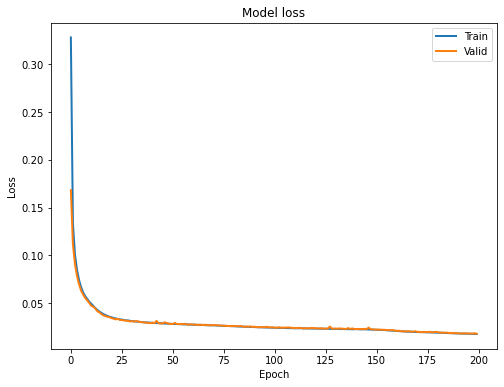

In [84]:
plt.plot(lstm_autoencoder_history['loss'], linewidth=2, label='Train')
plt.plot(lstm_autoencoder_history['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

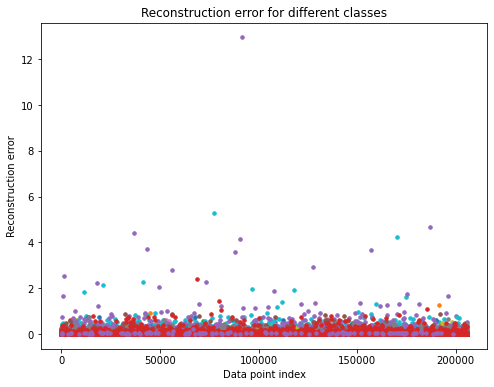

In [85]:
train_x_predictions = lstm_autoencoder.predict(X_train)
mse = np.mean(np.power(flatten(X_train) - flatten(train_x_predictions), 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_train.tolist()})

groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Break" if name == 1 else "Normal")
#ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

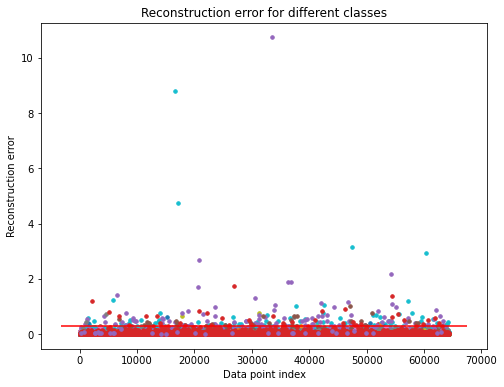

In [86]:
test_x_predictions = lstm_autoencoder.predict(X_test)
mse = np.mean(np.power(flatten(X_test) - flatten(test_x_predictions), 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_test.tolist()})

threshold_fixed = 0.3
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Break" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
#ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()